# Horizons

Data about the horizons can be loaded by first loading a simulation, then accessing the `horizons` attribute:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sxs

sxs_bbh_1234 = sxs.load("SXS:BBH:1234")
horizons = sxs_bbh_1234.horizons

  0%|                                                                | 0/2290092 [00:00<?, ?it/s]

The `horizons` object itself has three main attributes, which just store quantities related to the three component apparent horizons:

In [2]:
horizons.A, horizons.B, horizons.C

(<sxs.horizons.HorizonQuantities at 0x7f5b7667b670>,
 <sxs.horizons.HorizonQuantities at 0x7f5b7667b550>)

Horizon A corresponds to the first black hole during inspiral, horizon B to the second during inspiral, and horizon C to the final black hole — the common apparent horizon.

Each horizon object stores information about its masses (areal and Christodoulou), spins (dimensionless and dimensionful), and coordinate trajectory of the center of horizon.

We can list all the (public) attributes of each horizon:

In [3]:
[attribute for attribute in dir(horizons.A) if not attribute.startswith("_")]

['areal_mass',
 'chi_inertial',
 'chi_inertial_mag',
 'chi_mag_inertial',
 'christodoulou_mass',
 'coord_center_inertial',
 'dimensionful_inertial_spin',
 'dimensionful_inertial_spin_mag',
 'time']

[Note that `chi_mag_inertial` is just an alias for `chi_inertial_mag`, kept for backwards compatibility.  The `_mag` attributes just return the Euclidean norm of the corresponding vectors.]

For example, we can plot both types of masses for all three horizons:

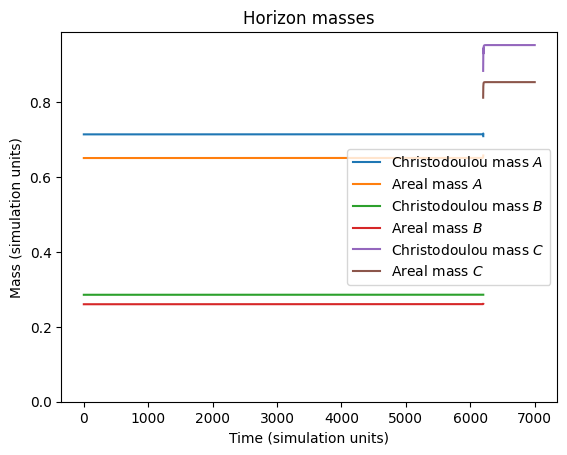

In [4]:
plt.plot(horizons.A.time, horizons.A.christodoulou_mass, label=r"Christodoulou mass $A$")
plt.plot(horizons.A.time, horizons.A.areal_mass, label=r"Areal mass $A$")
plt.plot(horizons.B.time, horizons.B.christodoulou_mass, label=r"Christodoulou mass $B$")
plt.plot(horizons.B.time, horizons.B.areal_mass, label=r"Areal mass $B$")
plt.plot(horizons.C.time, horizons.C.christodoulou_mass, label=r"Christodoulou mass $C$")
plt.plot(horizons.C.time, horizons.C.areal_mass, label=r"Areal mass $C$")
plt.title("Horizon masses")
plt.ylabel(r"Mass (simulation units)")
plt.xlabel(r"Time (simulation units)")
plt.ylim(bottom=0.0)
plt.legend();

Or we can plot the coordinate trajectory of horizon A:

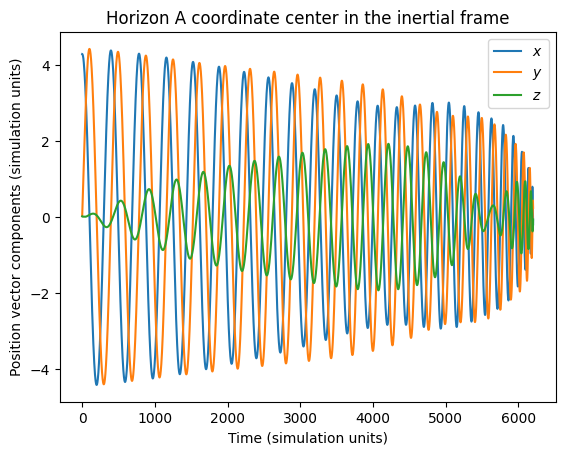

In [5]:
plt.plot(horizons.A.time, horizons.A.coord_center_inertial)
plt.title("Horizon A coordinate center in the inertial frame")
plt.ylabel(r"Position vector components (simulation units)")
plt.xlabel(r"Time (simulation units)")
plt.legend([r"$x$", r"$y$", r"$z$"]);

We can measure the Newtonian center of mass motion as a function of time:

In [6]:
com = horizons.newtonian_com

We will see below that the motion is distinctly non-inertial, so we also fit the measured motion to an averaged inertial motion:

In [7]:
# x_i and v_i are the best-fit initial translation and velocity
x_i, v_i, t_i, t_f = horizons.average_com_motion()

# Here, we express these as functions of time for plotting purposes
com_average = sxs.TimeSeries(
    x_i[np.newaxis] + v_i[np.newaxis] * horizons.A.time[:, np.newaxis],
    horizons.A.time
)

Now, we can plot them:

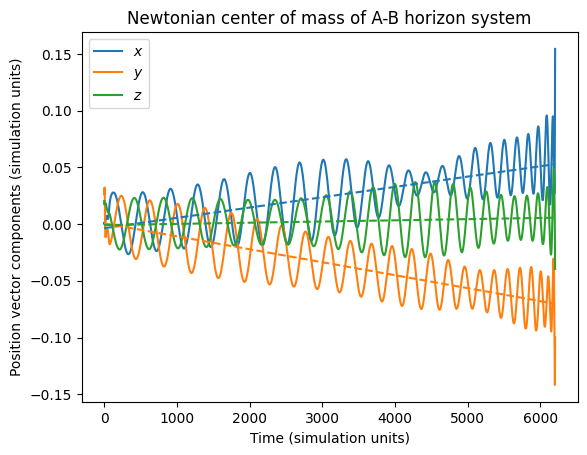

In [8]:
# Plot the measured and averaged components (and keep the lines)
measured = plt.plot(horizons.A.time, com)
averaged = plt.plot(horizons.A.time, com_average, ls='dashed')

# Copy colors from solid to dashed lines
for l1, l2 in zip(measured, averaged):
    l2.set_color(l1.get_color())

plt.title("Newtonian center of mass of A-B horizon system")
plt.ylabel(r"Position vector components (simulation units)")
plt.xlabel(r"Time (simulation units)")
plt.legend([r"$x$", r"$y$", r"$z$"]);

There are some remarkable features of this plot:

1. There are large oscillations that are not consistent with any motions we expect on physical grounds.
2. The oscillations change suddenly just before merger — right around the time a gauge change is applied in the simulation.  This suggests, of course, that the oscillations can be at least partially attributed to gauge weirdness.
3. Beyond the oscillations there is also significant drift, ending up near merger displaced by around $0.1M$ from the origin of coordinates.

The averaged motion is, of course, just a Poincaré transformation, so we can remove it from the data.  When we remove this transformation from the *waveforms* we find that certain unexpected features in the waveform disappear.  This was the subject of [this paper](https://arxiv.org/abs/1509.00862) as well as [a paper by CJ Woodford et al.](https://arxiv.org/abs/1904.04842), and we will see more about this in the next notebook.

## Backwards compatibility

Previously, the recommended way to load data from a file was to open it with `h5py`, and then directly extract datasets.  The user might do something like this:

```python
with h5py.File("Horizons.h5", "r") as horizons:
    time = horizons["AhA.dir/ArealMass.dat"][:, 0]
    areal_mass = horizons["AhA.dir/ArealMass.dat"][:, 1]
```

With newer data, this code will break because the format of the files has changed.  However, we can use the `horizons` object to provide an interface that is as close as possible to the old interface so that code that works with the old files can continue to work with new files, with a minimal set of changes.

In particular, it is still possible to extract that data from the `horizons` object:

In [9]:
horizons["AhA.dir/ArealMass.dat"]

array([[0.00000000e+00, 6.51026999e-01],
       [5.00000000e-01, 6.51034323e-01],
       [1.00000000e+00, 6.51040233e-01],
       ...,
       [6.20000000e+03, 6.54239851e-01],
       [6.20050000e+03, 6.55598731e-01],
       [6.20100000e+03, 6.57938033e-01]])

This actually reconstructs the arrays that the HDF5 file would contain on the fly.  The same is true for all of the datasets found in the old-format `Horizons.h5` files.  (And we will see that it is also true for waveform objects.)

In fact, we even have a simple little context manager that takes the place of `h5py.File`:

```python
with sxs.loadcontext("Horizons.h5") as horizons:
    time = horizons["AhA.dir/ArealMass.dat"][:, 0]
    areal_mass = horizons["AhA.dir/ArealMass.dat"][:, 1]
```

Thus, only ***one function call*** would need to change to use newer files.  (And in fact, the `loadcontext` function is even a bit nicer because it can handle the downloading and caching for you, just like `sxs.load`.)

However, be aware that this may not an be efficient use of memory, and is almost certainly slower than the newer interfaces.  Wherever possible, you should update your code to use newer interfaces.  Failing to do so will leave you open to ridicule from your peers and loved ones.

Continue with the [introduction to waveforms](/tutorials/04-Waveforms).